In [26]:
import pandas as pd
import numpy as np
import re, string
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [27]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import re
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk

# Contraction map
c_dict = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "I would",
    "i'd've": "I would have",
    "i'll": "I will",
    "i'll've": "I will have",
    "i'm": "I am",
    "i've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there had",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we had",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'alls": "you alls",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you had",
    "you'd've": "you would have",
    "you'll": "you you will",
    "you'll've": "you you will have",
    "you're": "you are",
    "you've": "you have"
}

# Compiling the contraction dict
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))

# List of stop words
add_stop = ['said', 'say', '...', 'like', 'cnn', 'ad']
stop_words = ENGLISH_STOP_WORDS.union(add_stop)

# List of punctuation
punc = list(set(string.punctuation))


# Splits words on white spaces (leaves contractions intact) and splits out
# trailing punctuation
def casual_tokenizer(text):
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    return tokens


def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)


def process_text(text):
    text = casual_tokenizer(text)
    text = [each.lower() for each in text]
    text = [re.sub('[0-9]+', '', each) for each in text]
    text = [expandContractions(each, c_re=c_re) for each in text]
    text = [SnowballStemmer('english').stem(each) for each in text]
    text = [w for w in text if w not in punc]
    text = [w for w in text if w not in stop_words]
    text = [each for each in text if len(each) > 1]
    text = [each for each in text if ' ' not in each]
    return text


def top_words(topic, n_top_words):
    return topic.argsort()[:-n_top_words - 1:-1]  


def topic_table(model, feature_names, n_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        t = (topic_idx)
        topics[t] = [feature_names[i] for i in top_words(topic, n_top_words)]
    return pd.DataFrame(topics)


def whitespace_tokenizer(text): 
    pattern = r"(?u)\b\w\w+\b" 
    tokenizer_regex = RegexpTokenizer(pattern)
    tokens = tokenizer_regex.tokenize(text)
    return tokens


# Funtion to remove duplicate words
def unique_words(text): 
    ulist = []
    [ulist.append(x) for x in text if x not in ulist]
    return ulist


def word_count(text):
    return len(str(text).split(' '))

In [28]:
#reading the fake and true datasets
fake_news = pd.read_csv('D:\\bits\\sem4\\project_dataset\\Fake.csv')
true_news = pd.read_csv('D:\\bits\\sem4\\project_dataset\\True.csv')

# print shape of fake dataset with rows and columns and information 
print ("The shape of the  data is (row, column):"+ str(fake_news.shape))
print (fake_news.info())
print("\n --------------------------------------- \n")

# print shape of true dataset with rows and columns and information
print ("The shape of the  data is (row, column):"+ str(true_news.shape))
print (true_news.info())

The shape of the  data is (row, column):(23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
None

 --------------------------------------- 

The shape of the  data is (row, column):(21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB
None


In [29]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1
#Concatenating and dropping for fake news
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

#Converting the date to datetime format
fake_news['date'] = pd.to_datetime(fake_news['date'])
true_news['date'] = pd.to_datetime(true_news['date'])

#combine all news
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

#Creating a copy 
clean_news=news_dataset.copy()

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0
4,News,2017-12-25,pope francis just called out donald trump dur...,0


In [30]:
# Process the text
clean_news['processed_text'] = clean_news['news'].apply(process_text)


NameError: name 'df' is not defined

In [31]:
clean_news.head()

,subject,date,news,output,processed_text
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0,"[donald, trump, send, embarrass, new, year, ev..."
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0,"[drunk, brag, trump, staffer, start, russian, ..."
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0,"[sheriff, david, clark, becom, internet, joke,..."
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0,"[trump, obsess, obama, code, websit, imageson,..."
4,News,2017-12-25,pope francis just called out donald trump dur...,0,"[pope, franci, just, donald, trump, dure, chri..."


In [32]:
# Get the word count
clean_news['word_count'] = clean_news['processed_text'].apply(word_count)
clean_news['word_count'].mean()

216.28907503118873

In [33]:
# Process the text
clean_news.head()

,subject,date,news,output,processed_text,word_count
0,News,2017-12-31,donald trump sends out embarrassing new year’...,0,"[donald, trump, send, embarrass, new, year, ev...",258
1,News,2017-12-31,drunk bragging trump staffer started russian ...,0,"[drunk, brag, trump, staffer, start, russian, ...",176
2,News,2017-12-30,sheriff david clarke becomes an internet joke...,0,"[sheriff, david, clark, becom, internet, joke,...",301
3,News,2017-12-29,trump is so obsessed he even has obama’s name...,0,"[trump, obsess, obama, code, websit, imageson,...",217
4,News,2017-12-25,pope francis just called out donald trump dur...,0,"[pope, franci, just, donald, trump, dure, chri...",191


In [34]:
# Descriptive statistics for word count
clean_news['word_count'].describe()

count    44888.000000
mean       216.289075
std        182.935069
min          3.000000
25%        113.000000
50%        192.000000
75%        269.000000
max       4536.000000
Name: word_count, dtype: float64

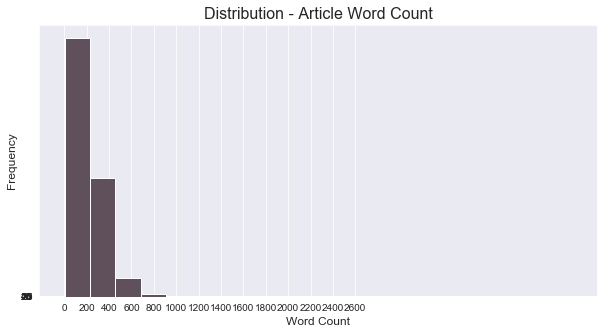

In [35]:
# Plot a hist of the word counts
fig = plt.figure(figsize=(10,5))

plt.hist(
    clean_news['word_count'],
    bins=20,
    color='#60505C'
)

plt.title('Distribution - Article Word Count', fontsize=16)
plt.ylabel('Frequency', fontsize=12)
plt.xlabel('Word Count', fontsize=12)
plt.yticks(np.arange(0, 50, 5))
plt.xticks(np.arange(0, 2700, 200))

plt.show()

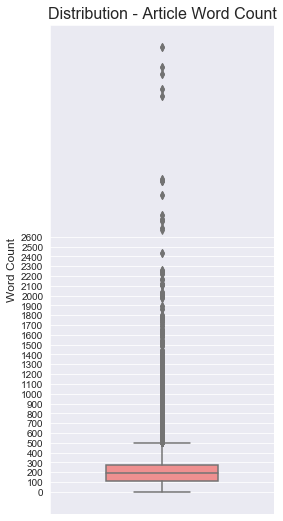

In [36]:
# Plot a boxplot of the word counts
fig = plt.figure(figsize=(4,9))

sns.boxplot(
    clean_news['word_count'],
    orient='v',
    width=.5,
    color='#ff8080'
)

plt.ylabel("Word Count", fontsize=12)
plt.title('Distribution - Article Word Count', fontsize=16)
plt.yticks(np.arange(0, 2700, 100))


plt.show()


In [38]:
# Get the top 20 most common words among all the articles
p_text = clean_news['processed_text']

# Flaten the list of lists
p_text = [item for sublist in p_text for item in sublist]

# Top 20
top_20 = pd.DataFrame(
    Counter(p_text).most_common(20),
    columns=['word', 'frequency']
)

top_20

,word,frequency
0,trump,141541
1,state,61494
2,presid,57718
3,peopl,41887
4,republican,39717
5,year,33978
6,new,31803
7,hous,30677
8,obama,30235
9,govern,30171


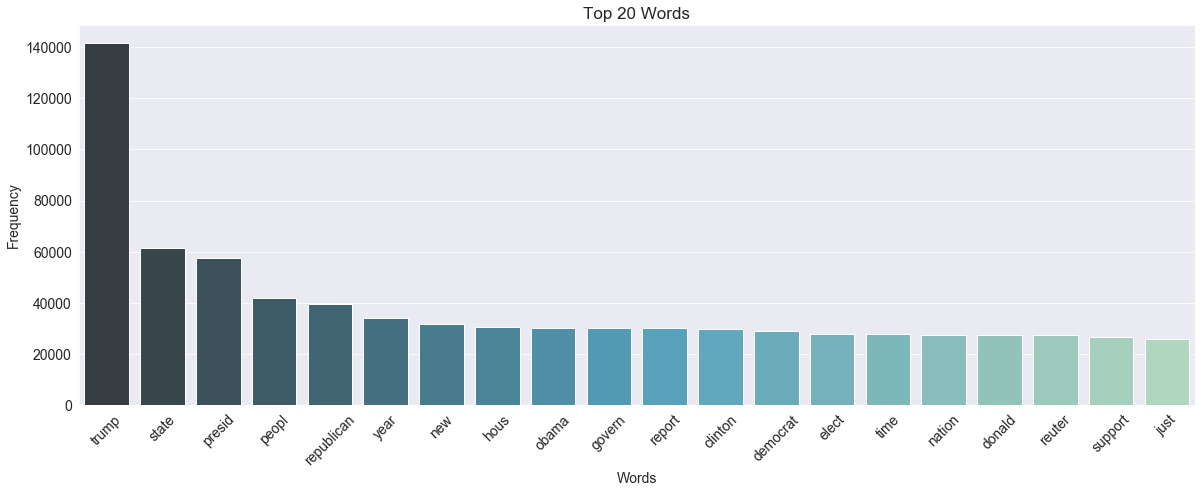

In [39]:
# Plot a bar chart for the top 20 most frequently occuring words
fig = plt.figure(figsize=(20,7))

g = sns.barplot(
    x='word',
    y='frequency',
    data=top_20,
    palette='GnBu_d'
)

g.set_xticklabels(
    g.get_xticklabels(),
    rotation=45,
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Top 20 Words', fontsize=17)


plt.show()

In [40]:
# Get the number of unique words after processing
num_unique_words = len(set(p_text))
num_unique_words

190093

In [42]:
# Used NMF to get the best num of topics via coherence score
texts = clean_news['processed_text']

# Create a dictionary
# In gensim a dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(
    no_below=3,
    no_above=0.85,
    keep_n=5000
)

# Create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# Create a list of the topic numbers we want to try
topic_nums = list(np.arange(5, 75 + 1, 5))

# Run the nmf model and calculate the coherence score
# for each number of topics
coherence_scores = []


In [43]:

for num in topic_nums:
    nmf = Nmf(
        corpus=corpus,
        num_topics=num,
        id2word=dictionary,
        chunksize=2000,
        passes=5,
        kappa=.1,
        minimum_probability=0.01,
        w_max_iter=300,
        w_stop_condition=0.0001,
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,
        normalize=True,
        random_state=42
    )
    
    # Run the coherence model to get the score
    cm = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(cm.get_coherence(), 5))



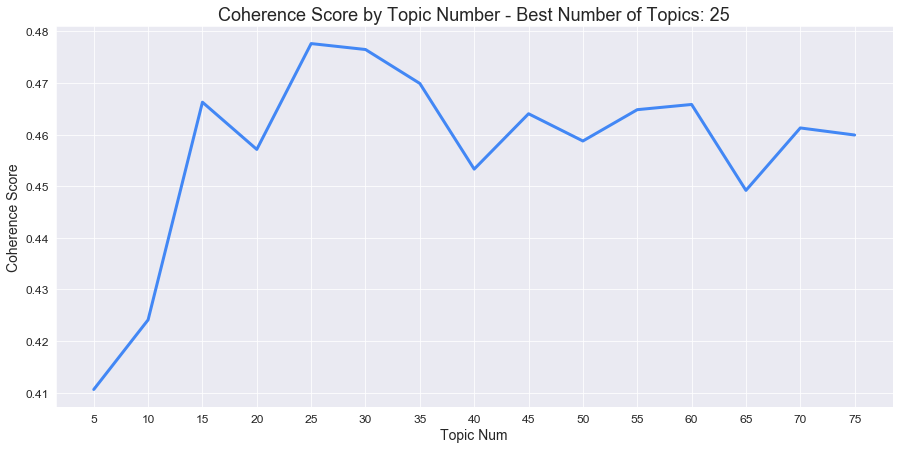

In [44]:
# Get the number of topics with the highest coherence score
scores = list(zip(topic_nums, coherence_scores))
best_num_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]

# Plot the results
fig = plt.figure(figsize=(15, 7))

plt.plot(
    topic_nums,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Num", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title('Coherence Score by Topic Number - Best Number of Topics: {}'.format(best_num_topics), fontsize=18)
plt.xticks(np.arange(5, max(topic_nums) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [45]:
# Now use the number of topics with the 
# highest coherence score to run the 
# sklearn nmf model

texts = clean_news['processed_text']

# Create the tfidf weights
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,
    max_df=0.85,
    max_features=5000,
    ngram_range=(1, 2),
    preprocessor=' '.join
)

tfidf = tfidf_vectorizer.fit_transform(texts)

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
    n_components=best_num_topics,
    init='nndsvd',
    max_iter=500,
    l1_ratio=0.0,
    solver='cd',
    alpha=0.0,
    tol=1e-4,
    random_state=42
).fit(tfidf)
# Use the top words for each cluster by tfidf weight
# to create 'topics'

# Getting a df with each topic by document
docweights = nmf.transform(tfidf_vectorizer.transform(texts))

n_top_words = 8

topic_df = topic_table(
    nmf,
    tfidf_fn,
    n_top_words
).T

# Cleaning up the top words to create topic summaries
topic_df['topics'] = topic_df.apply(lambda x: [' '.join(x)], axis=1) # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets
topic_df['topics'] = topic_df['topics'].apply(lambda x: whitespace_tokenizer(x)) # tokenize
topic_df['topics'] = topic_df['topics'].apply(lambda x: unique_words(x))  # Removing duplicate words
topic_df['topics'] = topic_df['topics'].apply(lambda x: [' '.join(x)])  # Joining each word into a list
topic_df['topics'] = topic_df['topics'].str[0]  # Removing the list brackets

topic_df.head()

,0,1,2,3,4,5,6,7,topics
0,trump,donald,donald trump,presid,campaign,support,republican,imag,trump donald presid campaign support republica...
1,compani,billion,fund,million,govern,bank,budget,year,compani billion fund million govern bank budge...
2,korea,north,north korea,korean,nuclear,missil,south,north korean,korea north korean nuclear missil south
3,tax,senat,republican,obamacar,healthcar,legisl,insur,repeal,tax senat republican obamacar healthcar legisl...
4,clinton,hillari,hillari clinton,email,campaign,sander,foundat,democrat,clinton hillari email campaign sander foundat ...


In [46]:
# Create a df with only the created topics and topic num
topic_df = topic_df['topics'].reset_index()
topic_df.columns = ['topic_num', 'topics']

topic_df.head()

,topic_num,topics
0,0,trump donald presid campaign support republica...
1,1,compani billion fund million govern bank budge...
2,2,korea north korean nuclear missil south
3,3,tax senat republican obamacar healthcar legisl...
4,4,clinton hillari email campaign sander foundat ...


In [57]:
# Creating a temp df with the url and topic num to join on
url = clean_news['news'].tolist()

df_temp = pd.DataFrame({
    'news': url,
    'topic_num': docweights.argmax(axis=1)
})

# Merging to get the topic num with url
merged_topic = df_temp.merge(
    topic_df,
    on='topic_num',
    how='left'
)

# Merging with the original df
df_topics = pd.merge(
    clean_news,
    merged_topic,
    on='news',
    how='left'
)

df_topics = df_topics.drop(
    'news',
    axis=1
)

df_topics.head()

,subject,date,output,processed_text,word_count,topic_num,topics
0,News,2017-12-31,0,"[donald, trump, send, embarrass, new, year, ev...",258,14,peopl just women know don video becaus news
1,News,2017-12-31,0,"[drunk, brag, trump, staffer, start, russian, ...",176,20,fbi comey investig email director committe depart
2,News,2017-12-30,0,"[sheriff, david, clark, becom, internet, joke,...",301,14,peopl just women know don video becaus news
3,News,2017-12-29,0,"[trump, obsess, obama, code, websit, imageson,...",217,10,obama presid barack cuba american
4,News,2017-12-25,0,"[pope, franci, just, donald, trump, dure, chri...",191,21,israel jerusalem palestinian isra netanyahu ca...


In [58]:
# Showing the 3 matrices we get witn nmf
A = tfidf_vectorizer.transform(texts)
W = nmf.components_
H = nmf.transform(A)

print('A = {} x {}'.format(A.shape[0], A.shape[1]))
print('W = {} x {}'.format(W.shape[0], W.shape[1]))
print('H = {} x {}'.format(H.shape[0], H.shape[1]))


A = 44888 x 5000
W = 25 x 5000
H = 44888 x 25


In [59]:
# Get the residuals for each document
r = np.zeros(A.shape[0])

for row in range(A.shape[0]):
    r[row] = np.linalg.norm(A[row, :] - H[row, :].dot(W), 'fro')

sum_sqrt_res = round(sum(np.sqrt(r)), 3)
'Sum of the squared residuals is {}'.format(sum_sqrt_res)

'Sum of the squared residuals is 43061.068'

In [61]:
# Add the residuals to the df
df_topics['resid'] = r

# Get the avg residual by topic
resid_data = df_topics[[
    'topic_num',
    'resid'
]].groupby('topic_num').mean().sort_values(by='resid')

# Plot a bar chart for the avg. residuls by topic
fig = plt.figure(figsize=(20,7))

x = 44888
y = resid_data['resid']
    
g = sns.barplot(
    x=x,
    y=y,
    order=x,
    palette='rocket'
)

g.set_xticklabels(
    g.get_xticklabels(),
    fontsize=14
)

plt.yticks(fontsize=14)
plt.xlabel('Topic Number', fontsize=14)
plt.ylabel('Residual', fontsize=14)
plt.title('Avg. Residuals by Topic Number', fontsize=17)

plt.show()

ValueError: Length of values (44888) does not match length of index (57482)

In [ ]:
# Predicting the topic for an unseen article

# Load the unseen articles for prediction
file_name = 'unseen_cnn_articles.csv'

df_new = pd.read_csv(file_path + file_name)

# Process the text
df_new['processed_text'] = df_new['body'].apply(process_text)

new_texts = df_new['processed_text']

# Transform the new data with the fitted models
tfidf_new = tfidf_vectorizer.transform(new_texts)
X_new = nmf.transform(tfidf_new)

# Get the top predicted topic
predicted_topics = [np.argsort(each)[::-1][0] for each in X_new]

# Add to the df
df_new['pred_topic_num'] = predicted_topics

df_new

In [ ]:
# Join with the original df to get the topic summary
df_new = pd.merge(
    df_new.drop('processed_text', axis=1),
    df_topics[['topic_num', 'topics']],
    left_on='pred_topic_num',
    right_on='topic_num',
    how='inner' 
).drop_duplicates().drop(['topic_num', 'url', 'date'], axis=1)

df_new

In [62]:
df_topics

,subject,date,output,processed_text,word_count,topic_num,topics
0,News,2017-12-31,0,"[donald, trump, send, embarrass, new, year, ev...",258,14,peopl just women know don video becaus news
1,News,2017-12-31,0,"[drunk, brag, trump, staffer, start, russian, ...",176,20,fbi comey investig email director committe depart
2,News,2017-12-30,0,"[sheriff, david, clark, becom, internet, joke,...",301,14,peopl just women know don video becaus news
3,News,2017-12-29,0,"[trump, obsess, obama, code, websit, imageson,...",217,10,obama presid barack cuba american
4,News,2017-12-25,0,"[pope, franci, just, donald, trump, dure, chri...",191,21,israel jerusalem palestinian isra netanyahu ca...
...,...,...,...,...,...,...,...
57477,worldnews,2017-08-22,1,"[fulli, commit, nato, new, approach, afghanist...",234,8,syria islam state syrian iraq forc militari
57478,worldnews,2017-08-22,1,"[lexisnexi, withdrew, product, chines, marketl...",73,16,china chines xi taiwan beij trade south sea
57479,worldnews,2017-08-22,1,"[minsk, cultur, hub, becom, haven, authorities...",159,1,compani billion fund million govern bank budge...
57480,worldnews,2017-08-22,1,"[vatican, upbeat, possibl, pope, franci, visit...",111,12,russia russian putin moscow intellig hack elec...
